In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

import spatialize.gs.esi.aggfunction as af
import spatialize.gs.esi.precfunction as pf
from spatialize import logging
from spatialize.gs.esi import esi_griddata

In [2]:
#logging.log.setLevel("DEBUG")


def func(x, y):  # a kind of "cubic" function
    return x * (1 - x) * np.cos(4 * np.pi * x) * np.sin(4 * np.pi * y ** 2) ** 2


grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

rng = np.random.default_rng()
points = rng.random((1000, 2))
values = func(points[:, 0], points[:, 1])

In [3]:
result = esi_griddata(points, values, (grid_x, grid_y),
                      local_interpolator="idw",
                      p_process="mondrian",
                      data_cond=False,
                      exponent=1.0,
                      n_partitions=500, alpha=0.985,
                      agg_function=af.mean
                      )

finished 100% of 500 iterations ... 

done (elpased time: 4.36s)


In [4]:
res=np.ma.array(result.esi_samples(), fill_value=0, mask=np.isnan(result.esi_samples())).filled()

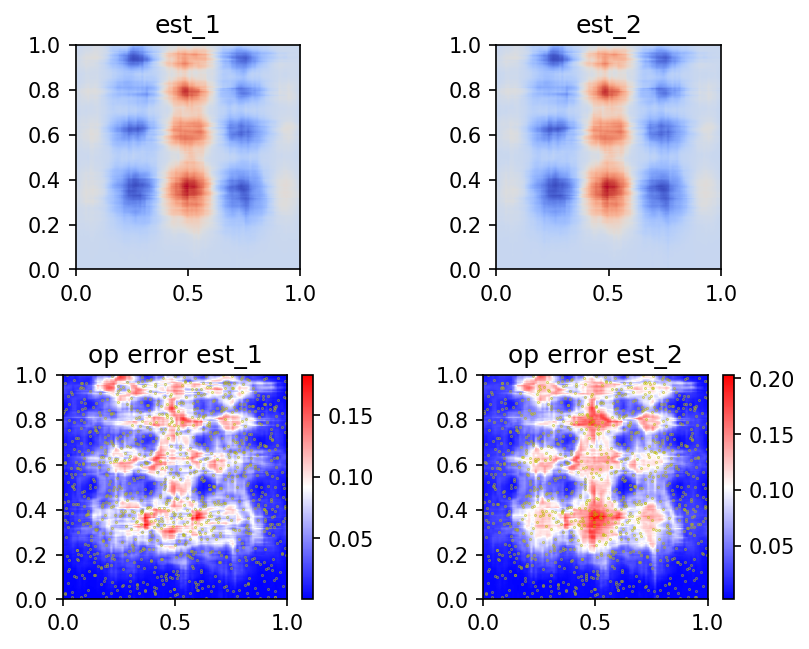

In [5]:
grid_cmap, prec_cmap = 'coolwarm', 'bwr'

fig = plt.figure(dpi=150)
gs = fig.add_gridspec(2, 2, wspace=0.3, hspace=0.47)
(ax1, ax2) = gs.subplots()
ax1, ax2, ax3, ax4 = ax1[0], ax1[1], ax2[0], ax2[1]

dirichlet_weighted_average = af.WeightedAverage()
est_1 = result.re_estimate(dirichlet_weighted_average) 

ax1.imshow(est_1.T, extent=(0, 1, 0, 1), origin='lower', cmap=grid_cmap)
ax1.set_title("est_1")

op_error = pf.OperationalErrorPrecision(np.abs(np.nanmin(result.esi_samples()) - np.nanmax(result.esi_samples())))

result.precision(op_error)
result.plot_precision(ax=ax3, cmap=prec_cmap)
ax3.set_title('op error est_1')
ax3.plot(points[:, 0], points[:, 1], 'y.', ms=0.5)

# second estimation
dirichlet_weighted_average = af.WeightedAverage(normalize=True)
est_2 = result.re_estimate(dirichlet_weighted_average)

ax2.imshow(est_2.T, extent=(0, 1, 0, 1), origin='lower', cmap=grid_cmap)
ax2.set_title("est_2")

op_error = pf.OperationalErrorPrecision(np.abs(np.nanmin(result.esi_samples()) - np.nanmax(result.esi_samples())))

result.precision(op_error)
result.plot_precision(ax=ax4, cmap=prec_cmap)
ax4.set_title('op error est_2')
ax4.plot(points[:, 0], points[:, 1], 'y.', ms=0.5)

plt.show()

In [4]:
precision = result.precision_cube(pf.mse_bilateral)
reshaped_precision = precision.reshape(result.esi_samples().shape)
prec_def = np.ma.array(reshaped_precision, fill_value=0, mask=np.isnan(reshaped_precision)).filled()

In [5]:
bill = af.Bilateral_Filter(prec_def)

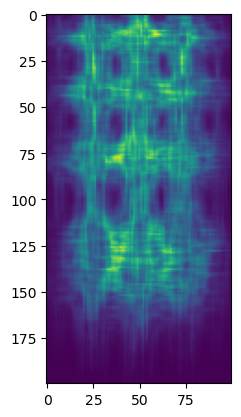

In [7]:
plt.imshow(bill.T)